## Artifical Thymic Organoids data - Batch correction with scVI

In [1]:
import sys,os
import scvi
import anndata
import matplotlib
import seaborn as sns
from matplotlib import colors
import matplotlib.pyplot as plt
from matplotlib import rcParams
from matplotlib.colors import LinearSegmentedColormap


import numpy as np
import pandas as pd
import scanpy as sc
import numpy.random as random

Global seed set to 0


In [2]:
import torch
device = torch.device("cuda")

In [3]:
## import utils
cwd = '/home/jupyter/Pan_fetal_immune/src/utils/'
sys.path.append(cwd)

import genes
import panfetal_utils

### Load dataset

In [ ]:
data_dir = '/home/jupyter/mount/gdrive/Pan_fetal/data4gpu_node/'

In [4]:
def subset_top_hvgs(adata_lognorm, n_top_genes):
    dispersion_norm = adata_lognorm.var['dispersions_norm'].values.astype('float32')

    dispersion_norm = dispersion_norm[~np.isnan(dispersion_norm)]
    dispersion_norm[
                ::-1
            ].sort()  # interestingly, np.argpartition is slightly slower

    disp_cut_off = dispersion_norm[n_top_genes - 1]
    gene_subset = adata_lognorm.var['dispersions_norm'].values >= disp_cut_off
    return(adata_lognorm[:,gene_subset])

ato_adata = sc.read_h5ad(data_dir + 'ATO_query.h5ad')
adata_lognorm_var = pd.read_csv(data_dir + 'ATO_query.var.csv')

ato_adata_scvi = ato_adata.copy()
ato_adata_scvi.var = adata_lognorm_var.copy()

ato_adata_scvi.var_names = ato_adata_scvi.var['gene_names'].values.copy()

### Feature selection

In [6]:
## Remove cell cycle genes
ato_adata_scvi = panfetal_utils.remove_geneset(ato_adata_scvi,genes.cc_genes)
ato_adata_scvi = panfetal_utils.remove_geneset(ato_adata_scvi, genes.IG_genes)
ato_adata_scvi = panfetal_utils.remove_geneset(ato_adata_scvi, genes.TCR_genes)

ato_adata_scvi = subset_top_hvgs(ato_adata_scvi, n_top_genes=5000).copy()

### Run scVI
Minimize difference between cell lines

In [7]:
ato_adata_scvi = scvi.data.setup_anndata(ato_adata_scvi, batch_key = "bbk", copy=True)
arches_params = dict(
    encode_covariates=True,
    dropout_rate=0.2,
    n_layers=2,
    )
vae = scvi.model.SCVI(ato_adata_scvi, n_latent=20, **arches_params)
vae.train(early_stopping=True,
    train_size=0.9,
    early_stopping_patience=45,
    max_epochs=400, 
    batch_size=1024, 
    limit_train_batches=20
   )

INFO     Using batches from adata.obs["bbk"]                                                 
INFO     No label_key inputted, assuming all cells have same label                           
INFO     Using data from adata.X                                                             
INFO     Successfully registered anndata object containing 10459 cells, 4999 vars, 2 batches,
         1 labels, and 0 proteins. Also registered 0 extra categorical covariates and 0 extra
         continuous covariates.                                                              
INFO     Please do not further modify adata until model is trained.                          


/opt/conda/envs/ed6/lib/python3.8/site-packages/sklearn/utils/deprecation.py:87: FutureWarning: Function setup_anndata is deprecated; Please use the model-specific setup_anndata methods instead. The global method will be removed in version 0.15.0.
  warnings.warn(msg, category=FutureWarning)
GPU available: True, used: True
TPU available: False, using: 0 TPU cores
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]


Epoch 400/400: 100%|██████████| 400/400 [02:47<00:00,  2.38it/s, loss=938, v_num=1]   


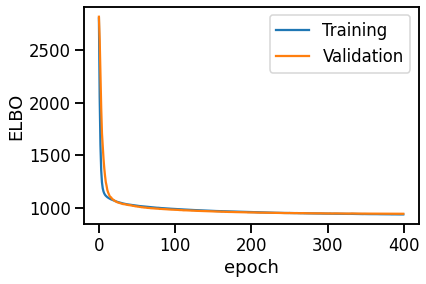

In [8]:
## Plot convergence
sns.set_context("talk")
plt.plot(vae.history["elbo_train"], label="Training");
plt.plot(vae.history["elbo_validation"], label="Validation");
plt.legend();
plt.xlabel("epoch");
plt.ylabel("ELBO");

### Clustering and embedding

In [9]:
ato_adata_scvi.obsm["X_scVI"] = vae.get_latent_representation()

In [10]:
sc.pp.neighbors(ato_adata_scvi, use_rep="X_scVI", n_neighbors=20)
sc.tl.umap(ato_adata_scvi)
sc.tl.leiden(ato_adata_scvi, resolution=1.5)

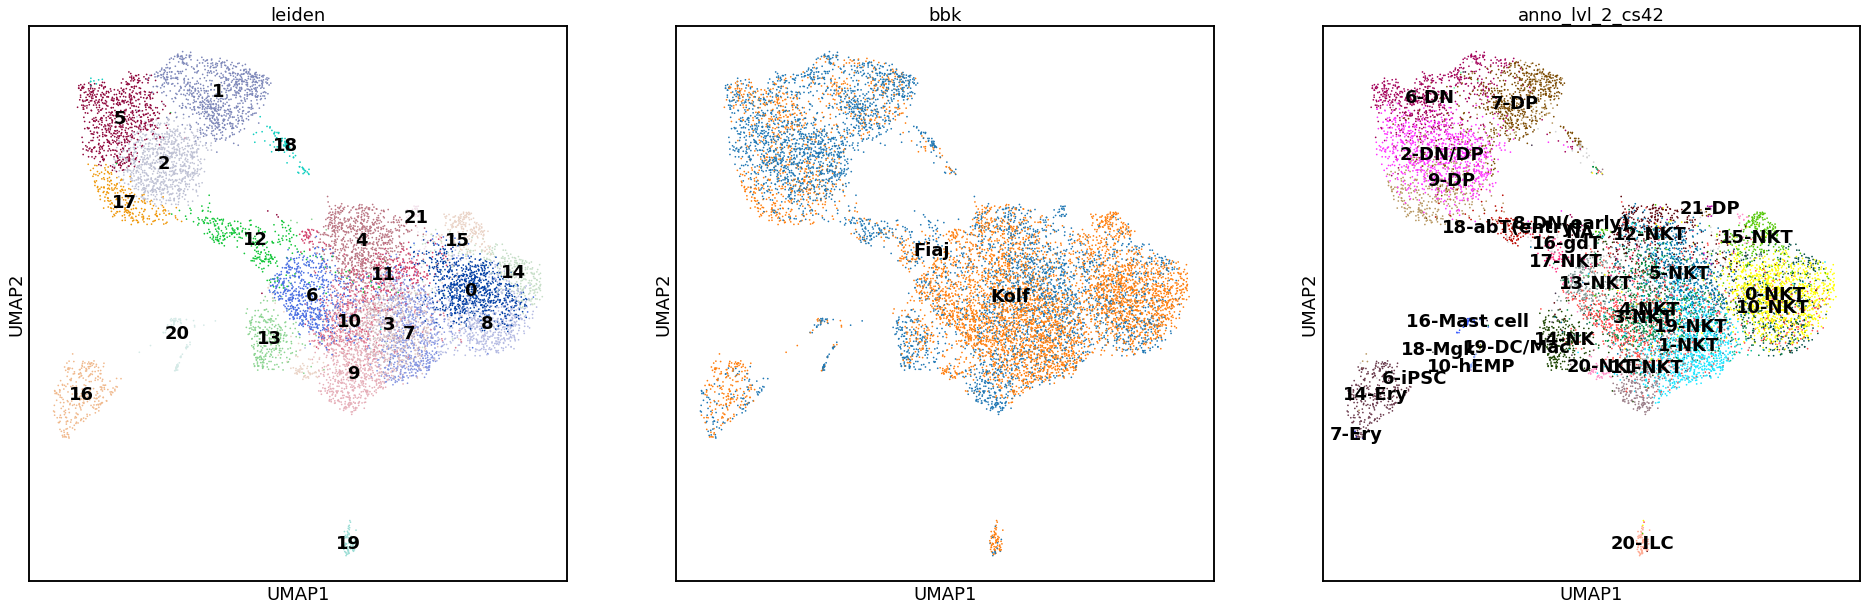

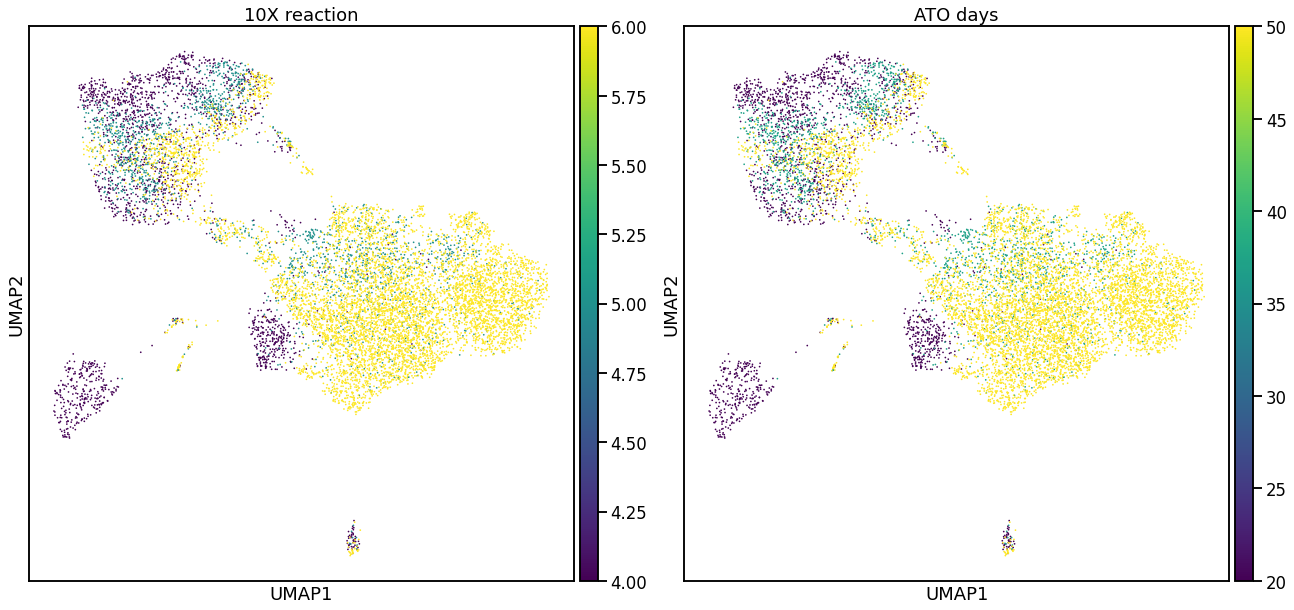

In [18]:
plt.rcParams['figure.figsize'] = [10,10]
sc.pl.umap(ato_adata_scvi, color=['leiden', 'bbk', 'anno_lvl_2_cs42'], legend_loc='on data')
sc.pl.umap(ato_adata_scvi, color=['10X reaction', "ATO days"], legend_loc='on data')

### Save outputs

In [12]:
ato_adata.obsm = ato_adata_scvi.obsm.copy()
ato_adata.obs = ato_adata_scvi.obs.copy()

In [13]:
ato_adata.write_h5ad(data_dir + 'ATO_query.scVI.h5ad')